# Modelo Perceptrón Multicapa
[MLP - Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../../drive')
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

Para entrenar este modelo hemos partido del conjunto de datos ya limpio con la variable GenresList transformada con OneHotEncoding.

In [3]:
# Descargamos los datos en formato parquet de Google Drive
drive.descargar_archivos_concretos('datosEntrenamiento.parquet', '../../drive')

Archivo datosEntrenamiento.parquet guardado en: ../data/clean/datosEntrenamiento.parquet


In [4]:
# data = pd.read_parquet('../data/clean/datosEntrenamiento.parquet')
data = pd.read_csv('/Users/maria/Downloads/ENTRENAMIENTO_FINAL.csv')

In [5]:
data.head()

,Unnamed: 0,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0,0.0,329.0,1.0,0.51,0.40,0,19.99,1.0,paperback,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,269.0,2.0,0.61,0.54,1,3.99,2.0,ebook,...,0,0,0,0,0,0,0,0,0,0
2,2,0.0,2335.0,1.0,0.72,0.57,1,20.99,7.0,ebook,...,0,0,0,0,1,0,0,0,0,0
3,3,0.0,40.0,1.0,0.83,0.35,0,25.00,1.0,hardcover,...,0,0,0,0,1,0,0,0,0,0
4,4,0.0,189.0,1.0,0.59,0.26,0,15.00,4.0,paperback,...,0,0,0,0,0,0,0,0,0,0


## Ajuste de hiperparámetros

In [6]:
import os
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

In [7]:
# Semilla
SEED = 22

# Proporción del conjunto de test
TEST_SIZE = 0.3

# Número de folds para la validación cruzada
CV_FOLDS = 5

In [8]:
def codificarPriceFormat(df):
    return pd.get_dummies(df, columns=['PriceFormat'], dtype=int)

### Métricas de evaluación

In [9]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [10]:
# Función para calcular la sensibilidad
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

# Función para calcular la especificidad
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Convertir las funciones en funciones de puntuación
sensitivity_scorer = make_scorer(sensitivity)
specificity_scorer = make_scorer(specificity)

METRICS = {'balanced_accuracy': 'balanced_accuracy',
           'sensitivity': sensitivity_scorer,
           'specificity': specificity_scorer}

### Preparamos entorno de Mlflow

In [11]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [12]:
# Sets the sqlite db as the MLFLOW_TRACKING_URI 
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'

# WARNING: TO SEE THE LOCAL SERVER YOU HAVE TO CHOOSE THE CORRECT BACKEND STORE AS FOLLOWS:
# mlflow ui --port 8080 --backend-store-uri sqlite:///mlruns.db


# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Para imprimir los experimentos que están en la base de datos

# Establecer la URI de seguimiento
mlflow.set_tracking_uri('sqlite:///mlruns.db')

# Obtener todos los experimentos
experiment_ids = mlflow.search_runs().experiment_id.unique()

# Imprimir los experimentos
for exp_id in experiment_ids:
    print(exp_id)
    
# Defino el experimento el que guardaré todas las ejecuciones
mlflow.set_experiment(experiment_name = 'MultiLayerPerceptron')

2024/04/28 01:33:13 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/28 01:33:13 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/maria/Dropbox/UCM/PD1/NOVELLA/modelos/MLP/mlruns/1', creation_time=1714260793743, experiment_id='1', last_update_time=1714260793743, lifecycle_stage='active', name='MultiLayerPerceptron', tags={}>

### Baseline Model

Creamos un modelo base para después comparar con los otros modelos que entrenemos con más técnicas de procesado y transformaciones. 

Modelo baseline:
* Parámetros por defecto
* Todas las variables
* Sin transformaciones

In [13]:
from sklearn.neural_network import MLPClassifier
import sklearn

In [14]:
dataBaseline = data.copy()
dataBaseline = codificarPriceFormat(dataBaseline)

In [17]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_base = dataBaseline.drop('Bestseller', axis=1)
y_base = dataBaseline['Bestseller']
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=TEST_SIZE, stratify=y_base, random_state=SEED)

In [18]:
PMC = sklearn.neural_network.MLPClassifier(random_state=SEED)

In [19]:
scores = cross_validate(PMC, X_base_train, y_base_train, scoring=METRICS, cv=CV_FOLDS,
                        return_train_score=True, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


In [20]:
scores

{'fit_time': array([2.12465405, 2.20799708, 2.63712096, 1.62038493, 2.06694722]),
 'score_time': array([0.01559711, 0.01360488, 0.01043105, 0.01252508, 0.01790786]),
 'test_balanced_accuracy': array([0.7215262 , 0.80168833, 0.7453437 , 0.62438028, 0.76547785]),
 'train_balanced_accuracy': array([0.80677319, 0.86733939, 0.85503997, 0.64617779, 0.83764488]),
 'test_sensitivity': array([0.5       , 0.70588235, 0.52941176, 0.26470588, 0.59701493]),
 'train_sensitivity': array([0.65682657, 0.80073801, 0.74538745, 0.29520295, 0.72426471]),
 'test_specificity': array([0.94305239, 0.89749431, 0.96127563, 0.98405467, 0.93394077]),
 'train_specificity': array([0.95671982, 0.93394077, 0.96469248, 0.99715262, 0.95102506])}

In [21]:
# Registramos los resultados en MlFlow
with mlflow.start_run():
    
    for metric in METRICS.keys():
        # Calculate the mean values for train and test sets
        train_mean = np.mean(scores[f"train_{metric}"])
        test_mean = np.mean(scores[f"test_{metric}"])

        # Log the mean values for train and test sets
        mlflow.log_metric(f"train_{metric}_mean", train_mean)
        mlflow.log_metric(f"test_{metric}_mean", test_mean)

    # Establece una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "Baseline (default) sinfic")

    # Infiere el signature del modelo, que describe el tipo de entrada y salida del modelo
    PMC.fit(X_base_train, y_base_train)
    signature = infer_signature(X_base_train, PMC.predict(X_base_train))

    # Registra el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=PMC,
        artifact_path="mlp_model",
        signature=signature,
        input_example=X_base_train,
        registered_model_name="baseline",
    )

/Users/maria/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/maria/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/04/28 01:34:24 WARNING mlflow.utils.validatio

### Escalado de variables

Para mejorar el rendimiento de la red neuronal, vamos a escalar las variables. Como los datos tienen muchos outliers, una estandarización sería muy susceptible a valores extremos. Por lo tanto, vamos a aplicar un [escalado robusto](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-robust-scaler-section), que usa la mediana y los rangos intercuartílicos. De esta forma la transformación será más resistente a las variaciones introducidas por datos atípicos.

In [22]:
from sklearn.preprocessing import RobustScaler

In [24]:
data_scaled = data.copy()
X_scaled = data_scaled.drop('Bestseller', axis=1)
y_scaled = data_scaled['Bestseller']

# Dividimos en train y test
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, y_scaled, test_size=TEST_SIZE, stratify=y_scaled, random_state=SEED)

In [25]:
# Inicializamos RobustScaler
scaler = RobustScaler()

# Solo lo aplicamos a las variables numéricas
# Incluimos 'Zombies' que no hay que escalar porque el RobustScaler ignora la primera columna de la lista 
# (hemos hecho pruebas)
variables_numericas = ['Zombies', 'SagaNumber', 'NumPages', 'RedPerc', 'BluePerc', 'Price', 'WordsTitle', 'BookInterest1M',
                     'Rating20Days', 'PrevBestSellAuthor']

# Aplicamos el RobustScaler a los datos de entrenamiento y test
X_scaled_train[variables_numericas] = scaler.fit_transform(X_scaled_train[variables_numericas])
X_scaled_test[variables_numericas] = scaler.transform(X_scaled_test[variables_numericas])

### Transformación de variables para el entrenamiento

Vamos a transformar la columna 'PriceFormat' con variables dummy para poder entrenar los modelos después.

In [26]:
X_to_train = X_scaled_train.copy()
X_to_train = codificarPriceFormat(X_to_train)

X_to_test = X_scaled_test.copy()
X_to_test = codificarPriceFormat(X_to_test)

### Creación de KFolds

Estrategia de [validación cruzada](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) con k folds

In [27]:
from sklearn.model_selection import StratifiedKFold

In [28]:
# Inicializamos el objeto KFold
kf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)

### Creación del pipeline

Creamos un pipeline con las operaciones que se deben aplicar a cada fold en el entrenamiento:
* Oversampling (SMOTENC)
* Redondear variables enteras
* Transformación variables categóricas con un valor único
* Clasificador (MLP)

In [29]:
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

In [30]:
def redondearVariables(X):
    variablesRedondeo = ["NumPages", "SagaNumber", "WordsTitle"]
    # Itera sobre las columnas especificadas y redondea sus valores
    for v in variablesRedondeo:
        X[v] = np.round(X[v])
    return X

In [31]:
# Columnas de los géneros
columnas_generos = X_scaled_train.columns[14:]

# Columnas categóricas
categoricalColumns = ["BelongsSaga", "PriceFormat", 'HasTwitter', 'HasWikipedia'] + list(columnas_generos)

In [32]:
smote = SMOTENC(categorical_features = categoricalColumns, random_state = SEED)

# Definimos el clasificador 
PMC = sklearn.neural_network.MLPClassifier(random_state=SEED)

# Definimos el transformador para codificar la variable categórica 'PriceFormat'
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['PriceFormat'])
], remainder='passthrough')

# Definimos el transformador de la función para redondear
transformador_funcion = FunctionTransformer(func=redondearVariables)

# Construimos el pipeline
pipeline = Pipeline([
    ('smote', smote),
    ('redondear_variables', transformador_funcion),
    ('encoder', column_transformer),
    ('classifier', PMC)
])

### Búsqueda de hiperparámetros

Vamos a buscar los hiperparámetros que optimicen el modelo probando una serie de combinaciones. Para ello, vamos a usar:
* Datos con escalado robusto
* Pipeline previamente creado
* Cross validation con k folds

Como las redes neuronales son muy costosas computacionalmente, vamos a dividir el ajuste de hiperparámetros en tres pasos.  Los dos primeros reducen mucho el número de opciones y por lo tanto optimizan el tiempo de ejecución.

1. Elegir la arquitectura más óptima de una serie de opciones mediante cross-validation con k folds
2. Ajustar el resto de hiperparámetros mediante GridSearch y RandomSearch tras fijar dicha arquitectura (para reducir el tiempo de entrenamiento)
3. Ajustar todos los hiperparámetros a la vez (incluida la arquitectura) mediante GridSearch y RandomSearch

Además, vamos a fijar la función de activación a 'logistic', que es la indicada para cuando la salida es una probabilidad.

### 1. Ajuste de la arquitectura de la red neuronal

In [33]:
# Definimos varias opciones para la distribución de las capas de neuronas
layers = [(50,), (100,), (50, 50), (100, 100), (200,), (150, 150), (200, 100), (100, 50, 25), (150, 100, 50)]

# Inicializamos la lista de scores
scores = {}

# Iterate over the list of hidden layer sizes
for hidden_layer_sizes in layers:
    # Set parameters for the neural network model inside the pipeline
    params = {'classifier__hidden_layer_sizes': hidden_layer_sizes,
              'classifier__activation':'logistic'}
    pipeline.set_params(**params)
    
    # Perform cross-validation
    cv_results = cross_validate(estimator=pipeline, X=X_scaled_train, y=y_scaled_train,
                                scoring=METRICS, cv=kf, return_train_score=True,
                                verbose=1, n_jobs=-1)
    
    # Append the results to the scores list
    scores[hidden_layer_sizes] = cv_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/maria/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.8s remaining:   28.2s
/Users/maria/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/maria/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend 

In [34]:
scores

{(50,): {'fit_time': array([17.40849566, 18.16318011, 18.53774595, 18.47975612, 16.69785213]),
  'score_time': array([0.01240444, 0.0077281 , 0.01255512, 0.01318693, 0.01522684]),
  'test_balanced_accuracy': array([0.80137009, 0.78780316, 0.78034973, 0.77185783, 0.7666168 ]),
  'train_balanced_accuracy': array([0.82426725, 0.83307101, 0.86157739, 0.87290912, 0.87018876]),
  'test_sensitivity': array([0.63235294, 0.60294118, 0.61764706, 0.60294118, 0.59701493]),
  'train_sensitivity': array([0.66789668, 0.68265683, 0.75276753, 0.7896679 , 0.78308824]),
  'test_specificity': array([0.97038724, 0.97266515, 0.94305239, 0.94077449, 0.93621868]),
  'train_specificity': array([0.98063781, 0.98348519, 0.97038724, 0.95615034, 0.95728929])},
 (100,): {'fit_time': array([23.30723691, 27.57325792, 27.90124202, 23.18618703, 23.87523794]),
  'score_time': array([0.01989293, 0.01733994, 0.01404285, 0.02275014, 0.01669717]),
  'test_balanced_accuracy': array([0.81535576, 0.77309728, 0.76512461, 0.7898

Estudiamos las gráficas de las métricas para cada distribución de las capas para elegir la óptima y poder ajustar el resto de hiperparámetros.

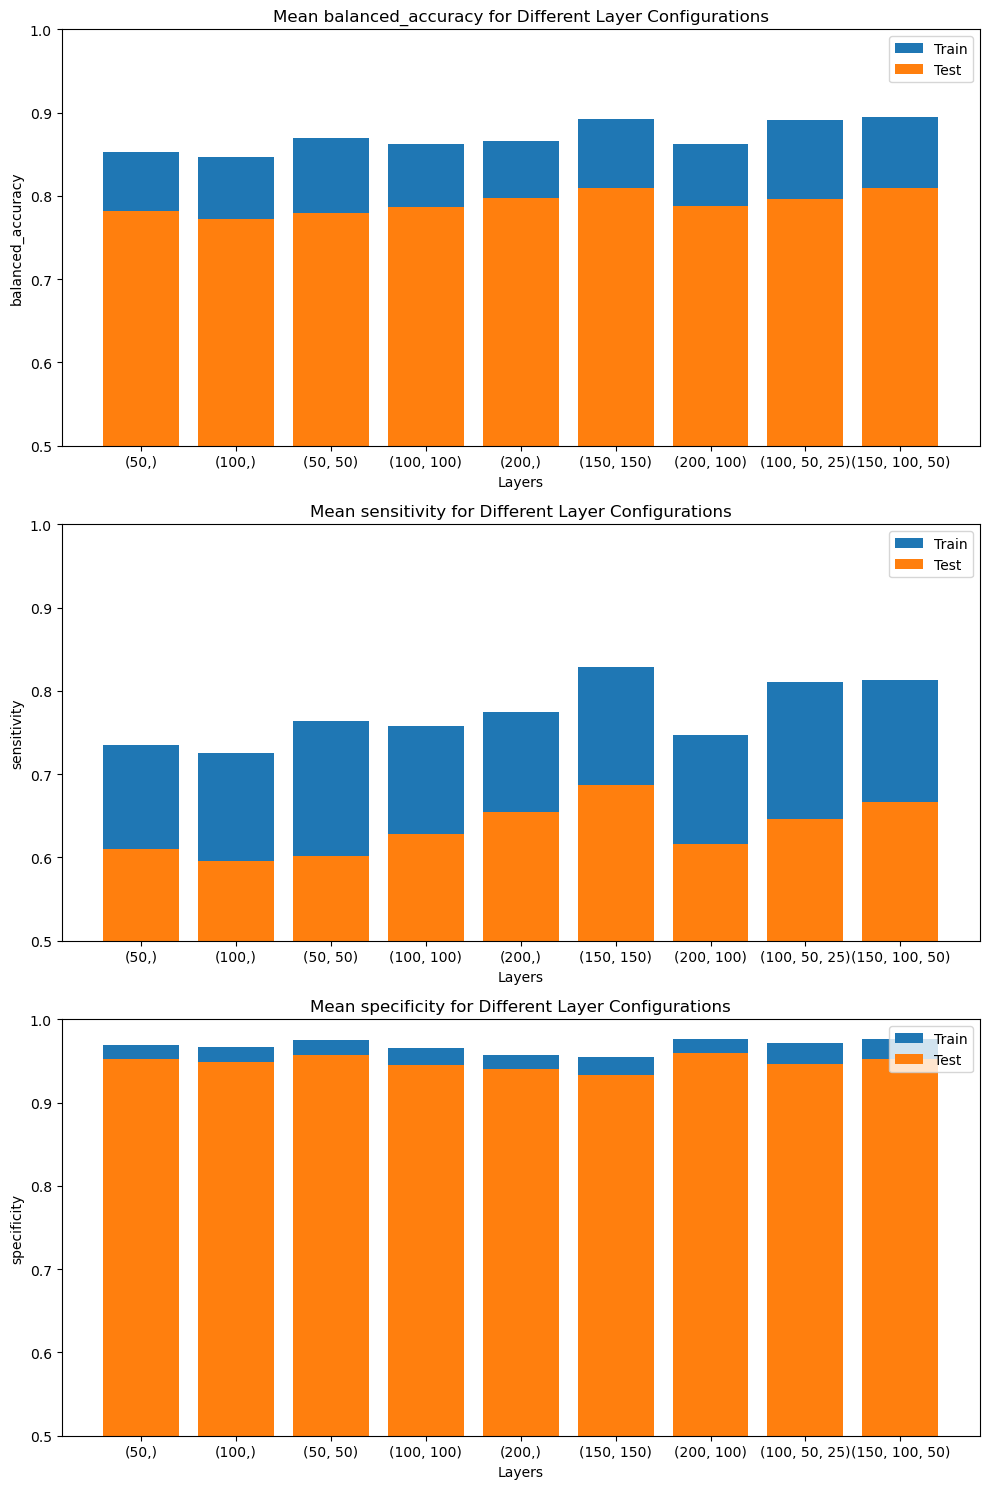

In [36]:
# Initialize subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for i, metric in enumerate(METRICS.keys()):
    # Initialize lists to store mean scores
    train_means = []
    test_means = []
    
    # Recorremos las capas
    for layer in layers:
        # Calculamos la media de esa métrica de entrenamiento y test
        train_mean = np.mean(scores[layer][f"train_{metric}"])
        test_mean = np.mean(scores[layer][f"test_{metric}"])

        # Append to lists
        train_means.append(train_mean)
        test_means.append(test_mean)
    
    # Mostramos las métricas en la gráfica
    axes[i].bar(range(len(layers)), train_means, label='Train')
    axes[i].bar(range(len(layers)), test_means, label='Test')
    
    # Set labels and title
    axes[i].set_xlabel('Layers')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'Mean {metric} for Different Layer Configurations')
    
    # Set xticks
    axes[i].set_xticks(range(len(layers)))
    axes[i].set_xticklabels(layers)
    
    # Set y-axis limits
    axes[i].set_ylim(0.5, 1)
        
    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

Estudiando las gráficas, observamos que tanto para balanced_accuracy como para sensitivity el valor de la métrica en el test encuentra su máximo en una distribución de (150, 150).
Aunque no es el caso para specificity (que se maximiza en (200, 100)), consigue un valor muy alto de 0.9.

Por lo tanto, elegimos la estructura (150, 150) apoyándonos en las dos primeras métricas para continuar ajustando los hiperparámetros en el siguiente paso.

In [37]:
LAYERS = (150, 150)

In [38]:
# Registramos los resultados en MlFlow del modelo con la mejor distribución de capas de neuronas
best_scores = scores[LAYERS]
best_params = {'classifier__hidden_layer_sizes': LAYERS,
              'classifier__activation':'logistic'}

# Como hemos usado cross validation esta vez, tenemos que crear un nuevo modelo con los parametros deseados
best_model = MLPClassifier(hidden_layer_sizes=LAYERS,
                           activation='logistic')


with mlflow.start_run():
    
    # Calculamos la media de las métricas del mejor parámetro y las almacenamos
    for metric in METRICS.keys():
        # Calculate the mean values for train and test sets
        train_mean = np.mean(best_scores[f"train_{metric}"])
        test_mean = np.mean(best_scores[f"test_{metric}"])
        
        # Calculate the standard deviations for train and test sets
        train_std = np.std(best_scores[f"train_{metric}"])
        test_std = np.std(best_scores[f"test_{metric}"])

        # Log the standard deviations for train and test sets
        mlflow.log_metric(f"train_{metric}_std", train_std)
        mlflow.log_metric(f"test_{metric}_std", test_std)

        # Log the mean values for train and test sets
        mlflow.log_metric(f"train_{metric}_mean", train_mean)
        mlflow.log_metric(f"test_{metric}_mean", test_mean)
    
    # Almacenamos los valores de los hiperparámetros
    for key, value in best_params.items():
        mlflow.log_param(key, value)
    
    # Establecemos una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "Ajuste capas neuronas. Con dataset escalado. sinfic")

    # Inferimos el signature del modelo, que describe el tipo de entrada y salida del modelo
    best_model.fit(X_to_train, y_scaled_train) # en este caso le metemos el df con las dummies de PriceFormat porque el modelo no tiene pipeline porque es el básico
    signature = infer_signature(X_to_train, best_model.predict(X_to_train))

    # Registramos el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="mlp_model",
        signature=signature,
        input_example=X_to_train,
        registered_model_name="ajuste_capas",
    )

/Users/maria/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/04/28 01:46:48 WARNING mlflow.utils.validation: Tag value '[{"run_id": "21c6d3c4468d4b889782632a0bae11aa", "artifact_path": "mlp_model", "utc_time_created": "2...' (22282 characters) is truncated to 5000 characters to meet the leng

### 2. Ajuste hiperparámetros adicionales

Vamos a determinar algunos parámetros por defecto para mejorar la eficiencia del modelo:
* **hidden_layer_sizes:** (150, 150) - obtenidos del experimento anterior
* **activation:** 'logistic' - la salida es una probabilidad
* **early_stopping:** True - detiene el entrenamiento de modelos cuando métricas que no mejoran
* **solver:** 'adam' - método por defecto. Optimiza el descenso de gradiente estocástico y se recomienda para datasets grandes (más de mil filas de entrenamiento)

### 2.1 Grid Search
[GridSearchCV - Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [39]:
# Definir los hiperparámetros a ajustar
param_grid = {
    'classifier__hidden_layer_sizes': [LAYERS],
    'classifier__activation': ['logistic'],
    'classifier__early_stopping': [True],
    'classifier__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1],
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'classifier__learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
}

# Inicializo GridSearch
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf,
                           scoring=METRICS, return_train_score=True,
                           refit='balanced_accuracy',
                           verbose=1, n_jobs=-1)

grid_search.fit(X_scaled_train, y_scaled_train)

# Resultados
cv_results_gr = grid_search.cv_results_
best_params_gr = grid_search.best_params_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


In [40]:
cv_results_gr

{'mean_fit_time': array([26.58535099, 20.81975527, 16.73834453, 16.22915306, 28.71924982,
        23.27891254, 17.61371193, 17.07552438, 29.71699762, 24.43355622,
        20.15509405, 17.56349177, 30.05197906, 23.08750253, 15.49260077,
        16.27141461, 29.70796523, 24.01458702, 16.58465452, 16.89647408,
        28.71956367, 23.90972395, 17.93828502, 18.87385802, 31.94563885,
        22.18046417, 14.72843003, 14.18119569, 25.86397991, 19.71019163,
        14.48148184, 14.02736154, 26.02012811, 19.15739579, 14.25854549,
        13.52567315, 25.96100802, 20.54489799, 14.65315213, 13.29056478,
        24.97704878, 19.50639124, 14.53495741, 13.22225375, 24.67643604,
        18.93479853, 13.81377254, 12.72247515, 24.9162641 , 17.81710796,
        13.58913803, 12.43583031, 25.13552804, 18.18371925, 13.93668904,
        12.84802284, 25.10255508, 18.75367365, 14.55774455, 12.44847221,
        25.94220843, 18.14082541, 13.44458442, 12.81763597, 25.88463221,
        18.26404362, 13.71867533, 

In [41]:
best_params_gr

{'classifier__activation': 'logistic',
 'classifier__alpha': 1,
 'classifier__early_stopping': True,
 'classifier__hidden_layer_sizes': (150, 150),
 'classifier__learning_rate': 'constant',
 'classifier__learning_rate_init': 0.001}

In [59]:
# Convertimos los resultados de la validación cruzada en un dataframe
df_results = pd.DataFrame(grid_search.cv_results_)
df_results

# Filtrando la fila con condiciones específicas
filtered_row = df_results.loc[
    (df_results['param_classifier__activation'] == 'logistic') &
    (df_results['param_classifier__alpha'] == 1) &
    (df_results['param_classifier__early_stopping'] == True) &
    (df_results['param_classifier__hidden_layer_sizes'] == (150, 150)) &
    (df_results['param_classifier__learning_rate'] == 'constant') &
    (df_results['param_classifier__learning_rate_init'] == 0.001)
]

index_row = filtered_row.index[0]

# Registro los resultados en MLFlow
with mlflow.start_run():

    # Almaceno los valores de los hiperparámetros
    for key, value in best_params.items():
        mlflow.log_param(key, value)

    # Registra las métricas de cada fold para cada métrica
    for metric in METRICS.keys():
        
        # Media
        mlflow.log_metric(f"mean_train_{metric}", df_results[f"mean_train_{metric}"][index_row])
        mlflow.log_metric(f"mean_test_{metric}", df_results[f"mean_test_{metric}"][index_row])

        # Desviación típica
        mlflow.log_metric(f"std_train_{metric}", df_results[f"std_train_{metric}"][index_row])
        mlflow.log_metric(f"std_test_{metric}", df_results[f"std_test_{metric}"][index_row])

        for i in range(5):

            # Resultados de entrenamiento en cada fold
            mlflow.log_metric(f"train_{metric}fold{i}", df_results[f"split{i}_train_{metric}"][index_row])
            # Resultados de validación en cada fold
            mlflow.log_metric(f"test_{metric}fold{i}", df_results[f"split{i}_test_{metric}"][index_row])

    # Establece una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "GridSearch 84 combinaciones. sinfic")

    # Infiere el signature del modelo, que describe el tipo de entrada y salida del modelo
    signature = infer_signature(X_scaled_train, grid_search.best_estimator_.predict(X_scaled_train))

    # Registra el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search,
        artifact_path="mlp_model",
        signature=signature,
        input_example=X_scaled_train,
        registered_model_name="mlp_gridsearch",
    )

/Users/maria/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/04/28 11:56:54 WARNING mlflow.utils.validation: Tag value '[{"run_id": "e1c5428339bb4ec5ae1e6319bb200628", "artifact_path": "mlp_model", "utc_time_created": "2...' (22120 characters) is truncated to 5000 characters to meet the leng

### 2.2 Random Search

[RandomizedSearchCV - sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Con esta estrategia podemos aprovechar un rango más amplio de posibles hiperparámetros sin comprometer la capacidad computacional, ya que coge un número fijo (`n_iter`) de combinaciones aleatorias dentro de los rangos establecidos. 

Para beneficiarnos más de esta técnica y aumentar la variedad, vamos a presentar los posibles valores de los parámetros continuos como distribuciones.

In [42]:
from scipy.stats import uniform, randint

In [68]:
# Defino las distribuciones de los parámetros
param_dist = {
    'classifier__hidden_layer_sizes': [LAYERS],
    'classifier__activation': ['logistic'],
    'classifier__early_stopping': [True],
    'classifier__alpha': uniform(0.00001, 1),
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'classifier__learning_rate_init': uniform(0.0001, 0.1)
}

# Inicializo RandomizedSearch
N_ITER = 84
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=N_ITER, cv=kf,
                                    scoring=METRICS, return_train_score=True,
                                    refit="balanced_accuracy",
                                    verbose=1, n_jobs=-1)

random_search.fit(X_scaled_train, y_scaled_train)

# Resultados
cv_results_rand = random_search.cv_results_
best_params_rand = random_search.best_params_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


In [69]:
cv_results_rand

{'mean_fit_time': array([11.56951537,  9.10348473,  9.87192369,  9.3142827 , 10.06285415,
         9.76468039,  9.45027752,  8.35551071,  7.47671847,  9.69924817,
         8.26404824,  7.62778144,  9.96234946,  7.95484653,  8.2268074 ,
         7.75106978,  7.73968673,  7.71264849,  8.8409626 ,  8.16882863,
         7.58212376,  7.94431324,  7.82593765,  8.05413828,  8.16997652,
         8.19563632,  7.99102759,  8.22263675,  7.94842858,  7.95001249,
         8.51812215,  8.35831895,  8.01961803,  7.65736151,  8.56740012,
         8.76795511,  7.74659534,  8.29305372,  7.89078803,  8.19654956,
         8.60006304,  7.99725943,  8.12159801,  7.91562724,  8.48831587,
         8.17407675,  7.87400079,  8.47872372,  8.20798416, 11.00647206,
         8.45372205,  8.82169304,  8.45829201,  8.31176395,  9.02223177,
        10.05631309,  8.11710863,  8.13685284,  8.04384379,  7.94366879,
         8.05411563,  8.22297487,  9.09068542,  8.12298808,  8.24290934,
         8.31779723,  8.23348989, 

In [70]:
best_params_rand

{'classifier__activation': 'logistic',
 'classifier__alpha': 0.8773407884629941,
 'classifier__early_stopping': True,
 'classifier__hidden_layer_sizes': (150, 150),
 'classifier__learning_rate': 'adaptive',
 'classifier__learning_rate_init': 0.0023019050769459534}

In [75]:
# Convertimos los resultados de la validación cruzada en un dataframe
df_results = pd.DataFrame(random_search.cv_results_)
df_results

# Filtrando la fila con condiciones específicas
filtered_row = df_results.loc[
    (df_results['param_classifier__activation'] == 'logistic') &
    (df_results['param_classifier__alpha'] == 0.8773407884629941) &
    (df_results['param_classifier__early_stopping'] == True) &
    (df_results['param_classifier__hidden_layer_sizes'] == (150, 150)) &
    (df_results['param_classifier__learning_rate'] == 'adaptive') &
    (df_results['param_classifier__learning_rate_init'] == 0.0023019050769459534)
]

index_row = filtered_row.index[0]

# Registro los resultados en MLFlow
with mlflow.start_run():

    # Almaceno los valores de los hiperparámetros
    for key, value in best_params.items():
        mlflow.log_param(key, value)

    # Registra las métricas de cada fold para cada métrica
    for metric in METRICS.keys():
        
        # Media
        mlflow.log_metric(f"mean_train_{metric}", df_results[f"mean_train_{metric}"][index_row])
        mlflow.log_metric(f"mean_test_{metric}", df_results[f"mean_test_{metric}"][index_row])

        # Desviación típica
        mlflow.log_metric(f"std_train_{metric}", df_results[f"std_train_{metric}"][index_row])
        mlflow.log_metric(f"std_test_{metric}", df_results[f"std_test_{metric}"][index_row])

        for i in range(5):

            # Resultados de entrenamiento en cada fold
            mlflow.log_metric(f"train_{metric}fold{i}", df_results[f"split{i}_train_{metric}"][index_row])
            # Resultados de validación en cada fold
            mlflow.log_metric(f"test_{metric}fold{i}", df_results[f"split{i}_test_{metric}"][index_row])

    # Establece una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "RandomizedSearch 84 combinaciones. sinfic")

    # Infiere el signature del modelo, que describe el tipo de entrada y salida del modelo
    signature = infer_signature(X_scaled_train, random_search.best_estimator_.predict(X_scaled_train))

    # Registra el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=random_search,
        artifact_path="mlp_model",
        signature=signature,
        input_example=X_scaled_train,
        registered_model_name="mlp_randomizedsearch",
    )

/Users/maria/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/04/28 14:29:12 WARNING mlflow.utils.validation: Tag value '[{"run_id": "8c2da395658847e2b4c7ba6114ef8d60", "artifact_path": "mlp_model", "utc_time_created": "2...' (22120 characters) is truncated to 5000 characters to meet the leng

### 3. Ajuste combinado de hiperparámetros
Vamos a intentar aplicar las estrategias de búsqueda a todos los hiperparámetros a la vez para ver si mejora el resultado.

### 3.1 Grid Search
[GridSearchCV - Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [71]:
# Definir los hiperparámetros a ajustar (135)
# Dejamos solo las opciones de arquitectura que eran las más prometedoras en la prueba individual (2 capas)
param_grid = {
    'classifier__hidden_layer_sizes': [(100, 100), (150, 150), (200, 100)],
    'classifier__activation': ['logistic'],
    'classifier__early_stopping': [True],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1],
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1]
}

# Inicializo GridSearch
grid_search3 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf,
                           scoring=METRICS, return_train_score=True,
                           refit='balanced_accuracy',
                           verbose=1, n_jobs=-1)

grid_search3.fit(X_scaled_train, y_scaled_train)

# Resultados
cv_results_gr3 = grid_search3.cv_results_
best_params_gr3 = grid_search3.best_params_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [72]:
best_params_gr3

{'classifier__activation': 'logistic',
 'classifier__alpha': 1,
 'classifier__early_stopping': True,
 'classifier__hidden_layer_sizes': (150, 150),
 'classifier__learning_rate': 'constant',
 'classifier__learning_rate_init': 0.001}

In [76]:
# Convertimos los resultados de la validación cruzada en un dataframe
df_results = pd.DataFrame(grid_search3.cv_results_)
df_results

# Filtrando la fila con condiciones específicas
filtered_row = df_results.loc[
    (df_results['param_classifier__activation'] == 'logistic') &
    (df_results['param_classifier__alpha'] == 1) &
    (df_results['param_classifier__early_stopping'] == True) &
    (df_results['param_classifier__hidden_layer_sizes'] == (150, 150)) &
    (df_results['param_classifier__learning_rate'] == 'constant') &
    (df_results['param_classifier__learning_rate_init'] == 0.001)
]

index_row = filtered_row.index[0]

# Registro los resultados en MLFlow
with mlflow.start_run():

    # Almaceno los valores de los hiperparámetros
    for key, value in best_params.items():
        mlflow.log_param(key, value)

    # Registra las métricas de cada fold para cada métrica
    for metric in METRICS.keys():
        
        # Media
        mlflow.log_metric(f"mean_train_{metric}", df_results[f"mean_train_{metric}"][index_row])
        mlflow.log_metric(f"mean_test_{metric}", df_results[f"mean_test_{metric}"][index_row])

        # Desviación típica
        mlflow.log_metric(f"std_train_{metric}", df_results[f"std_train_{metric}"][index_row])
        mlflow.log_metric(f"std_test_{metric}", df_results[f"std_test_{metric}"][index_row])

        for i in range(5):

            # Resultados de entrenamiento en cada fold
            mlflow.log_metric(f"train_{metric}fold{i}", df_results[f"split{i}_train_{metric}"][index_row])
            # Resultados de validación en cada fold
            mlflow.log_metric(f"test_{metric}fold{i}", df_results[f"split{i}_test_{metric}"][index_row])

    # Establece una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "GridSearch 135 combinaciones. sinfic")

    # Infiere el signature del modelo, que describe el tipo de entrada y salida del modelo
    signature = infer_signature(X_scaled_train, grid_search.best_estimator_.predict(X_scaled_train))

    # Registra el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search,
        artifact_path="mlp_model",
        signature=signature,
        input_example=X_scaled_train,
        registered_model_name="mlp_gridsearch",
    )

/Users/maria/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/04/28 14:29:43 WARNING mlflow.utils.validation: Tag value '[{"run_id": "f061c4093a9e4983a8e1f57fef6bf831", "artifact_path": "mlp_model", "utc_time_created": "2...' (22120 characters) is truncated to 5000 characters to meet the leng

### 3.2 Random Search
[RandomizedSearchCV - sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [73]:
# Defino las distribuciones de los parámetros
param_grid = {
    'classifier__hidden_layer_sizes': [(100, 100), (150, 150), (200, 100)],
    'classifier__activation': ['logistic'],
    'classifier__early_stopping': [True],
    'classifier__alpha': uniform(0.00001, 1),
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'classifier__learning_rate_init': uniform(0.0001, 0.1)
}

# Inicializo RandomizedSearch
N_ITER = 135
random_search3 = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=N_ITER, cv=kf,
                                    scoring=METRICS, return_train_score=True,
                                    refit="balanced_accuracy",
                                    verbose=1, n_jobs=-1)

random_search3.fit(X_scaled_train, y_scaled_train)

# Resultados
cv_results_rand3 = random_search3.cv_results_
best_params_rand3 = random_search3.best_params_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


In [74]:
best_params_rand3

{'classifier__activation': 'logistic',
 'classifier__alpha': 0.18324441181200563,
 'classifier__early_stopping': True,
 'classifier__hidden_layer_sizes': (150, 150),
 'classifier__learning_rate': 'adaptive',
 'classifier__learning_rate_init': 0.0001757617926269938}

In [78]:
# Convertimos los resultados de la validación cruzada en un dataframe
df_results = pd.DataFrame(random_search3.cv_results_)
df_results

# Filtrando la fila con condiciones específicas
filtered_row = df_results.loc[
    (df_results['param_classifier__activation'] == 'logistic') &
    (df_results['param_classifier__alpha'] == 0.18324441181200563) &
    (df_results['param_classifier__early_stopping'] == True) &
    (df_results['param_classifier__hidden_layer_sizes'] == (150, 150)) &
    (df_results['param_classifier__learning_rate'] == 'adaptive') &
    (df_results['param_classifier__learning_rate_init'] == 0.0001757617926269938)
]

index_row = filtered_row.index[0]

# Registro los resultados en MLFlow
with mlflow.start_run():

    # Almaceno los valores de los hiperparámetros
    for key, value in best_params.items():
        mlflow.log_param(key, value)

    # Registra las métricas de cada fold para cada métrica
    for metric in METRICS.keys():
        
        # Media
        mlflow.log_metric(f"mean_train_{metric}", df_results[f"mean_train_{metric}"][index_row])
        mlflow.log_metric(f"mean_test_{metric}", df_results[f"mean_test_{metric}"][index_row])

        # Desviación típica
        mlflow.log_metric(f"std_train_{metric}", df_results[f"std_train_{metric}"][index_row])
        mlflow.log_metric(f"std_test_{metric}", df_results[f"std_test_{metric}"][index_row])

        for i in range(5):

            # Resultados de entrenamiento en cada fold
            mlflow.log_metric(f"train_{metric}fold{i}", df_results[f"split{i}_train_{metric}"][index_row])
            # Resultados de validación en cada fold
            mlflow.log_metric(f"test_{metric}fold{i}", df_results[f"split{i}_test_{metric}"][index_row])

    # Establece una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "RandomizedSearch 135 combinaciones. sinfic")

    # Infiere el signature del modelo, que describe el tipo de entrada y salida del modelo
    signature = infer_signature(X_scaled_train, random_search.best_estimator_.predict(X_scaled_train))

    # Registra el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=random_search,
        artifact_path="mlp_model",
        signature=signature,
        input_example=X_scaled_train,
        registered_model_name="mlp_randomizedsearch",
    )

/Users/maria/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/04/28 14:31:05 WARNING mlflow.utils.validation: Tag value '[{"run_id": "fa7b7d4033574571996229ad87aceb64", "artifact_path": "mlp_model", "utc_time_created": "2...' (22120 characters) is truncated to 5000 characters to meet the leng